**Objective**

It is quite obvious that daily cash withdrawal amounts are time series. Therefore, in this typical cash demand forecast models we will present time series and regression machine learning models to troubleshoot the above use case. We will work on the demand for a single ATM (a group of ATMs can also be worked that is treated as a single ATM) to develop a model for the given data set.

We have to remember that, cash withdrawals from an ATM are not only time dependent. There could be seasonality, e.g. 1) people will have a tendency to withdraw money on Friday for the weekend or 2) end of the month when people get their salaries or 3) between 7–10th day of each month some people get their pension.

So our goal is to predict the amount of transactions for the next few days

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


*Reading Files*

In [ ]:

atm = pd.read_csv('/content/atms_data.csv')

In [ ]:
atm.shape

(511415, 8)

In [ ]:
atm.head()

,Unnamed: 0,Date,ATM_ID,Number_of_Trxs,Amount,capacity,Weekday,Working_day
0,0,20180201,3479212,199,235250,NaN,Thursday,Yes
1,1,20180201,1599756,105,237300,NaN,Thursday,Yes
2,2,20180201,2019227,487,539910,720000.0,Thursday,Yes
3,3,20180201,3200101,354,466900,NaN,Thursday,Yes
4,4,20180201,5129042,224,432610,NaN,Thursday,Yes


In [ ]:
atm.ATM_ID.nunique()

2675

In [ ]:
# Select numerical columns
numerical = atm.select_dtypes(include='number')

# Loop through each numerical column and use the describe function
for column in numerical.columns:
    print(f"Column: {column}"'\n')
    print(numerical[column].describe())
    print("-" * 50)


Column: Unnamed: 0

count    511415.000000
mean     255707.000000
std      147632.938296
min           0.000000
25%      127853.500000
50%      255707.000000
75%      383560.500000
max      511414.000000
Name: Unnamed: 0, dtype: float64
--------------------------------------------------
Column: Date

count    5.114150e+05
mean     2.018070e+07
std      3.081630e+02
min      2.018020e+07
25%      2.018050e+07
50%      2.018071e+07
75%      2.018101e+07
max      2.018123e+07
Name: Date, dtype: float64
--------------------------------------------------
Column: ATM_ID

count    5.114150e+05
mean     3.061007e+06
std      1.314356e+06
min      1.009104e+06
25%      2.019374e+06
50%      3.050455e+06
75%      4.009450e+06
max      7.089115e+06
Name: ATM_ID, dtype: float64
--------------------------------------------------
Column: Number_of_Trxs

count    511415.000000
mean        136.440550
std         118.767971
min           1.000000
25%          46.000000
50%         107.000000
75%       

*Checking for outliers*

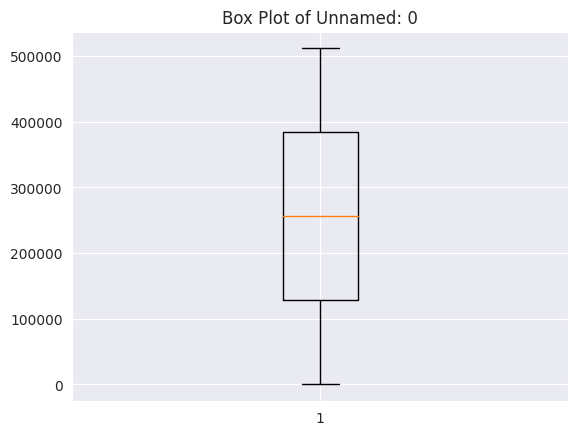

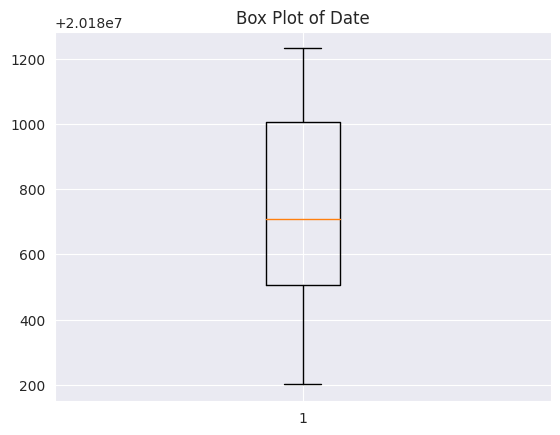

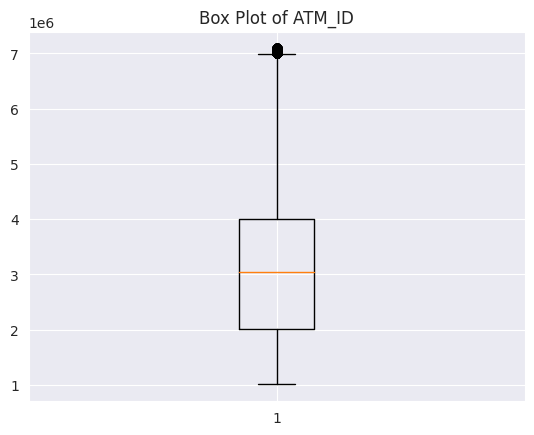

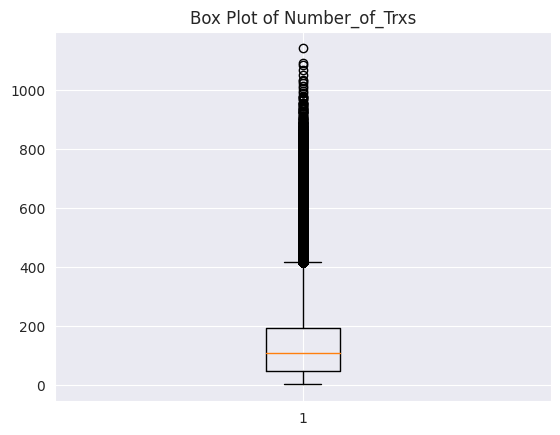

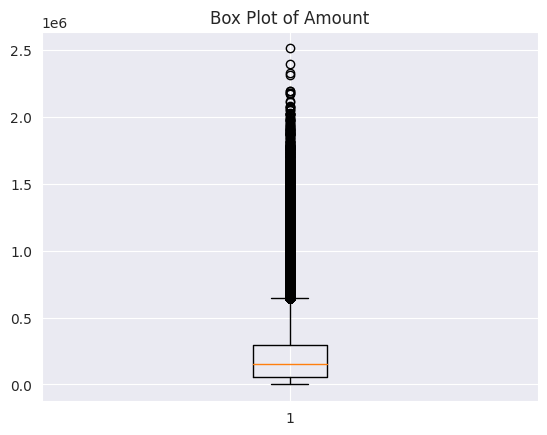

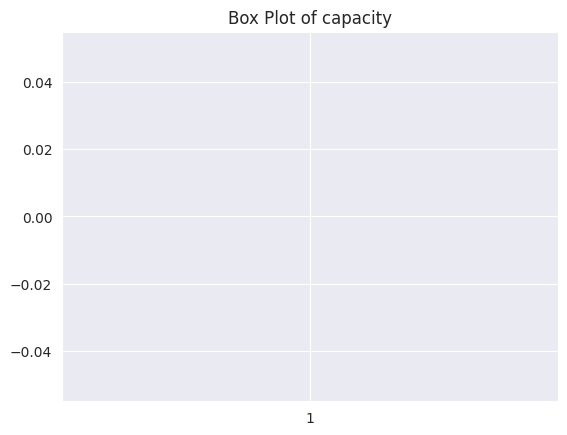

In [ ]:
# Select only the numeric columns (continuous data) with more than 2 unique values
continuous_cols = [col for col in numerical if atm[col].nunique() > 2]

# Loop through each continuous column and create a box plot
for column in continuous_cols:
    plt.figure()
    plt.boxplot(atm[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

*onehot encoding*

In [ ]:
# Select categorical columns
categorical = atm.select_dtypes(include='object')


In [ ]:
one_hot_encoded_data = pd.get_dummies(categorical)
one_hot_encoded_data.head()

,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Working_day_No,Working_day_Yes
0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0,0,1


In [ ]:
combined_data = pd.concat([one_hot_encoded_data, numerical], axis=1)

In [ ]:
filtered_df = atm[atm['capacity'].notnull()]
occurrences = filtered_df['ATM_ID'].value_counts()
print(occurrences)

3239501    248
1089574    248
2079266    248
4439432    246
4439955    246
          ... 
3149296      1
1879351      1
1879348      1
1779109      1
3229525      1
Name: ATM_ID, Length: 706, dtype: int64


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
df = atm[atm['ATM_ID'] == 1089574]  # Replace Column_name and condition as needed
print(df)

        Unnamed: 0      Date   ATM_ID  Number_of_Trxs  Amount  capacity    Weekday Working_day
669            669  20180203  1089574              62   72700  900000.0   Saturday          No
1818          1818  20180208  1089574             126  184560  900000.0   Thursday         Yes
6111          6111  20180225  1089574             361  516390  900000.0     Sunday         Yes
8476          8476  20180206  1089574             114  124610  900000.0    Tuesday         Yes
9547          9547  20180210  1089574             144  219940  900000.0   Saturday          No
9900          9900  20180212  1089574             109   91350  900000.0     Monday         Yes
12435        12435  20180222  1089574             145  168980  900000.0   Thursday         Yes
12818        12818  20180223  1089574              53  106650  900000.0     Friday          No
14134        14134  20180228  1089574             136  203530  900000.0  Wednesday         Yes
14310        14310  20180201  1089574             

# EDA

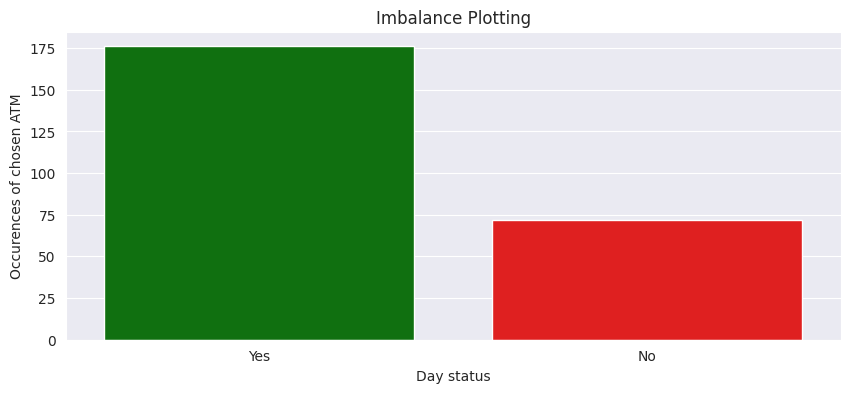

In [ ]:
Imbalance = df["Working_day"].value_counts().reset_index() #function is used to count the occurrences of each category in the target variable "TARGET"

plt.figure(figsize=(10,4))
labels= ['Yes','No']
sns.barplot(x=labels,y="Working_day",data = Imbalance,palette= ['g','r'])
plt.xlabel("Day status")
plt.ylabel("Occurences of chosen ATM")
plt.title("Imbalance Plotting")
plt.show()

# Modelling


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'Date', 'ATM_ID', 'Number_of_Trxs', 'Amount', 'capacity', 'Weekday', 'Working_day'], dtype='object')


In [ ]:
print(df.head())

      Unnamed: 0      Date   ATM_ID  Number_of_Trxs  Amount  capacity   Weekday Working_day
669          669  20180203  1089574              62   72700  900000.0  Saturday          No
1818        1818  20180208  1089574             126  184560  900000.0  Thursday         Yes
6111        6111  20180225  1089574             361  516390  900000.0    Sunday         Yes
8476        8476  20180206  1089574             114  124610  900000.0   Tuesday         Yes
9547        9547  20180210  1089574             144  219940  900000.0  Saturday          No


In [ ]:
# Huber loss function
def huber_loss(y_pred, y, delta=1.0):
    huber_mse = 0.5 * (y - y_pred) ** 2
    huber_mae = delta * (np.abs(y - y_pred) - 0.5 * delta)
    return np.where(np.abs(y - y_pred) <= delta, huber_mse, huber_mae)

# Time series Decomposition

In [ ]:
#'Date' is the column you want to set as index
df.set_index('Date', inplace=True)


In [ ]:
df.index = pd.to_datetime(df.index, format='%Y%m%d')

*Checking if date is sorted*

In [ ]:
if df.index.is_monotonic_increasing:
    print("Dates are sorted in ascending order.")
else:
    print("Dates are not sorted in ascending order.")

Dates are not sorted in ascending order.


In [ ]:
# Sort the DataFrame by the datetime index
data_sorted = df.sort_index()

In [ ]:
if data_sorted.index.is_monotonic_increasing:
    print("Dates are sorted in ascending order.")
else:
    print("Dates are not sorted in ascending order.")

Dates are sorted in ascending order.


**Handling missing Values**

*Months April and August are missing*

Insight: Imputation by median

In [ ]:
# Step 1: Create a new DataFrame with complete date range
date_range = pd.date_range(start=data_sorted.index.min(), end=data_sorted.index.max(), freq='D')
new_data = pd.DataFrame(index=date_range)

In [ ]:
# Step 2: Merge the new DataFrame with original data
merged_data = pd.merge(new_data, data_sorted, how='left', left_index=True, right_index=True)

In [ ]:
# Step 3: Impute missing values with median of each month
imputed_data = merged_data.resample('D').median()
# Impute missing values using median for all columns
imputed_data = imputed_data.fillna(imputed_data.median())

In [ ]:
print(imputed_data)

            Unnamed: 0     ATM_ID  Number_of_Trxs    Amount  capacity
2018-02-01     14310.0  1089574.0           182.0  170350.0  900000.0
2018-02-02     21792.0  1089574.0            57.0   85140.0  900000.0
2018-02-03       669.0  1089574.0            62.0   72700.0  900000.0
2018-02-04     50490.0  1089574.0           130.0  113750.0  900000.0
2018-02-05     36556.0  1089574.0           183.0  212680.0  900000.0
2018-02-06      8476.0  1089574.0           114.0  124610.0  900000.0
2018-02-07     16002.0  1089574.0            81.0   94450.0  900000.0
2018-02-08      1818.0  1089574.0           126.0  184560.0  900000.0
2018-02-09     30538.0  1089574.0            45.0   61230.0  900000.0
2018-02-10      9547.0  1089574.0           144.0  219940.0  900000.0
2018-02-11     52153.0  1089574.0           223.0  199880.0  900000.0
2018-02-12      9900.0  1089574.0           109.0   91350.0  900000.0
2018-02-13     31612.0  1089574.0           101.0   84180.0  900000.0
2018-02-14     52907

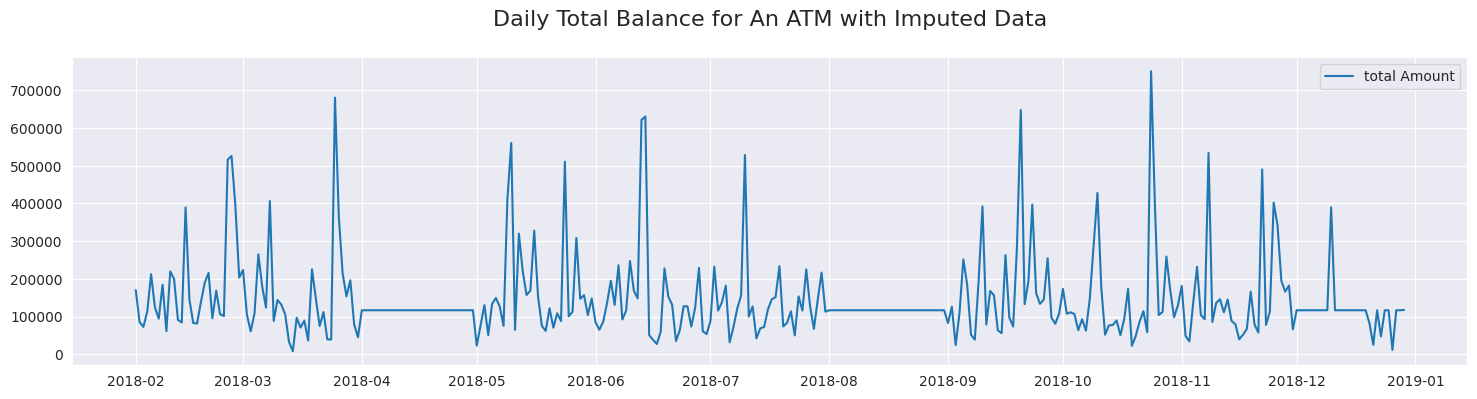

In [ ]:
# Plot the imputed data

plt.figure(figsize=(18, 4))
plt.plot(imputed_data.index, imputed_data['Amount'], label='total Amount')
plt.legend(loc='best')
plt.title('Daily Total Balance for An ATM with Imputed Data\n',
          fontdict={'fontsize': 16, 'fontweight': 5})
plt.show()

In [ ]:
data_daily = imputed_data.asfreq('D')

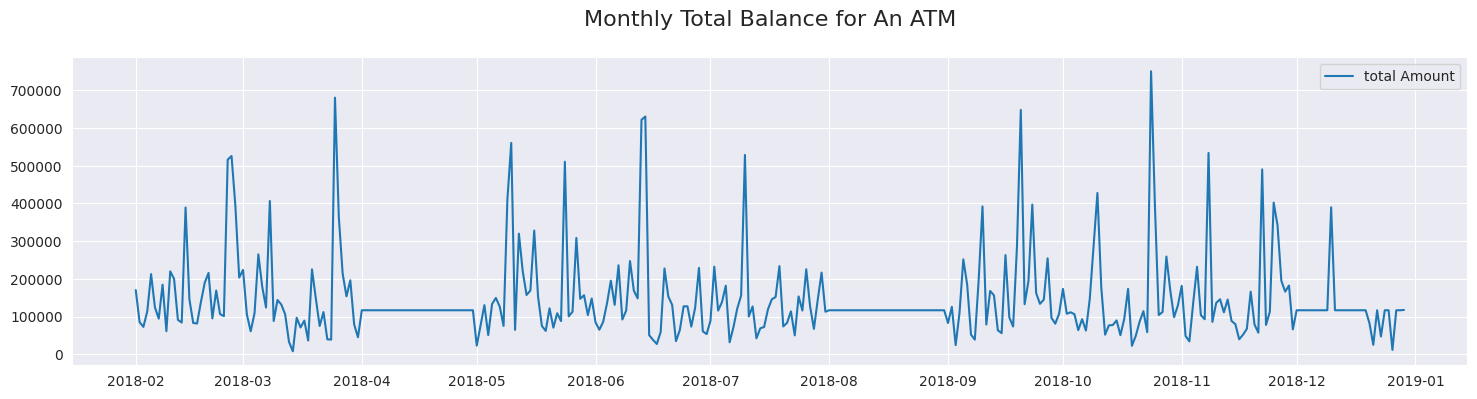

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(imputed_data['Amount'], label='total Amount')
plt.legend(loc='best')
plt.title('Monthly Total Balance for An ATM\n',
          fontdict={'fontsize': 16,
                    'fontweight': 5})
plt.show()



### **Additive seasonal decomposition**





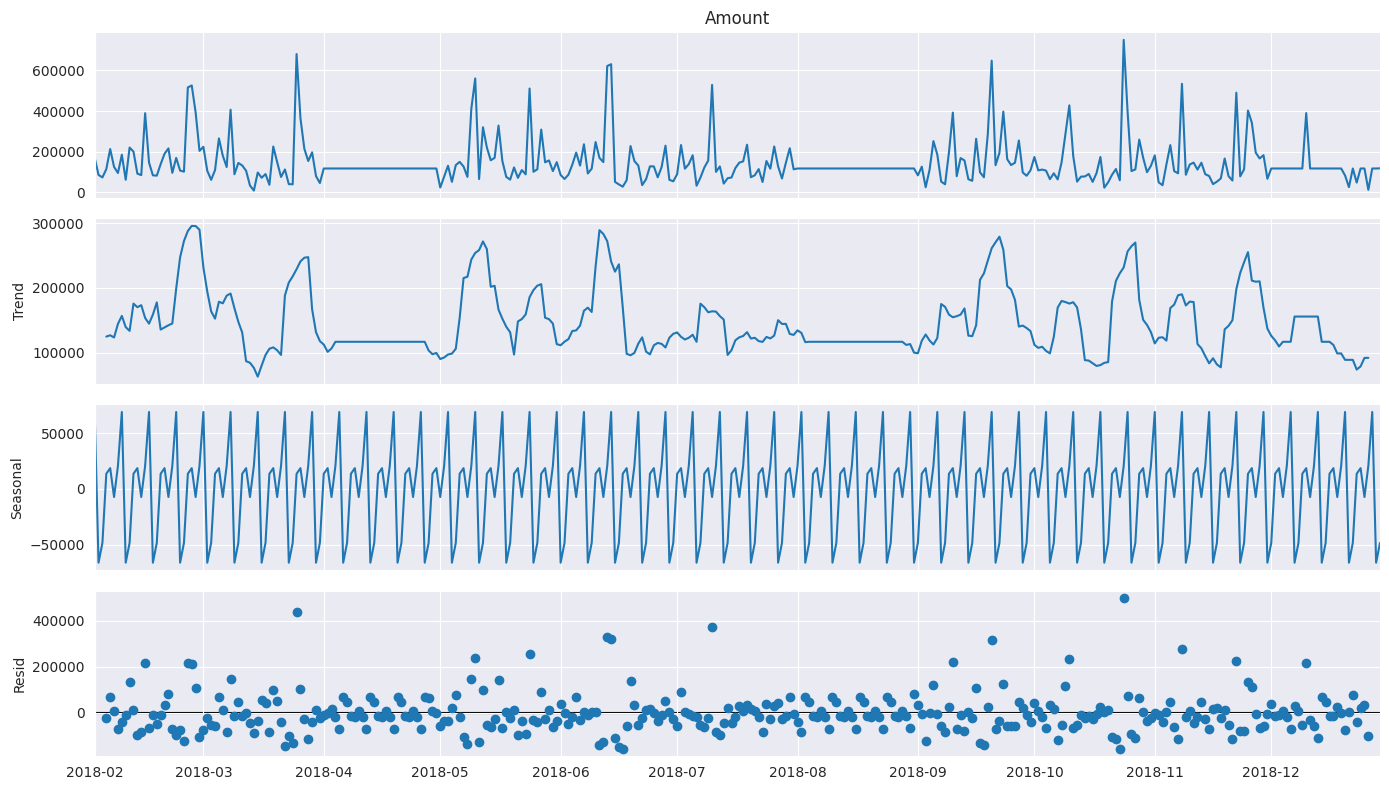

In [ ]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = (14,8)
decomposition = sm.tsa.seasonal_decompose(imputed_data['Amount'], model='additive')
fig = decomposition.plot()
plt.show()



### **Multiplicative seasonal decomposition**


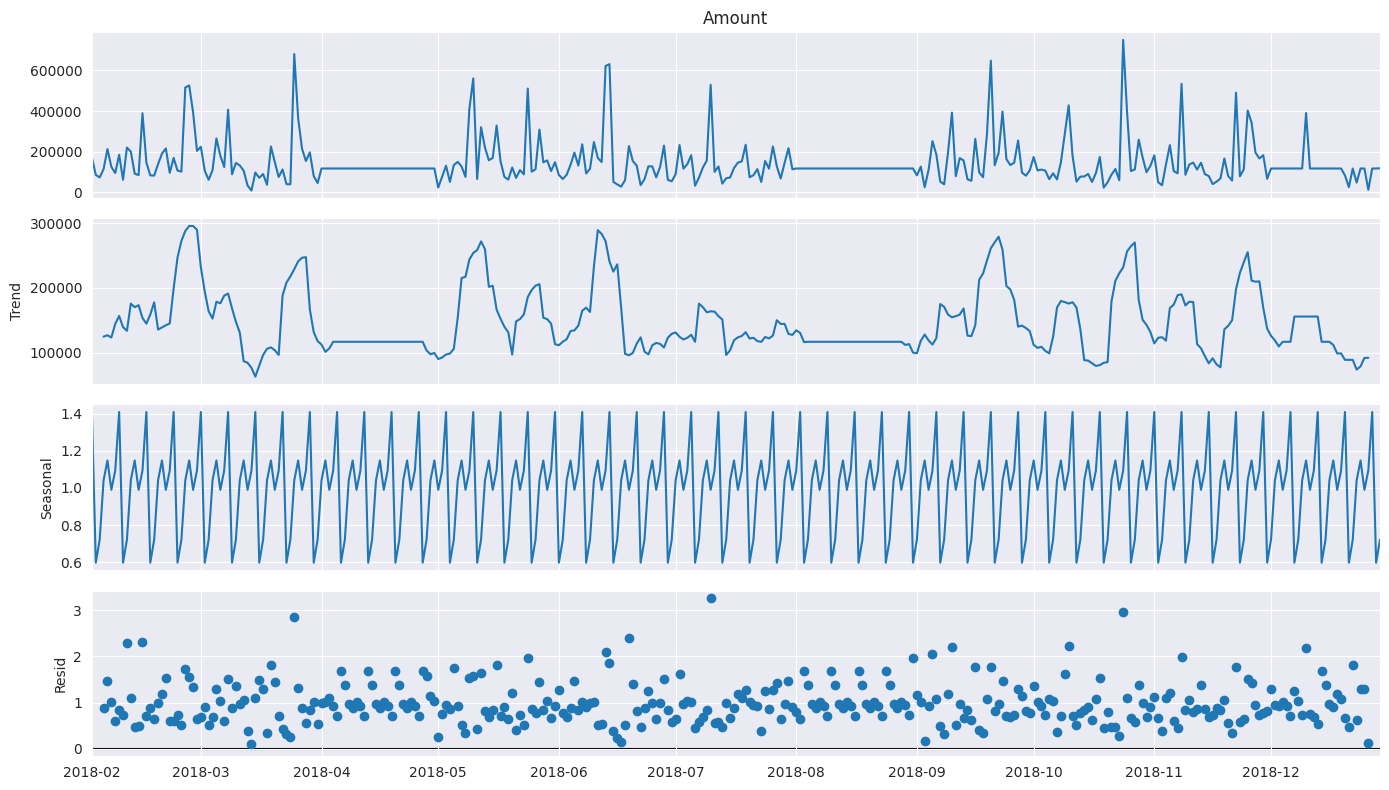

In [ ]:
decomposition = sm.tsa.seasonal_decompose(imputed_data.Amount, model='multiplicative')
fig = decomposition.plot()
plt.show()

* **Inference** : The data does not contain level, trend and seasonality.

# Data Preprocessing

**Check Stationary**

Augmented Dickey-Fuller (ADF) test

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(imputed_data['Amount'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])


ADF Statistic: -4.470102
Critical Values @ 0.05: -2.87
p-value: 0.000223


**Inference** : p-value is smaller than 0.05. This means that the series is stationary.

# Check ACF & PACF




In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
# Visualizations
lag_acf = 20
lag_pacf = 20

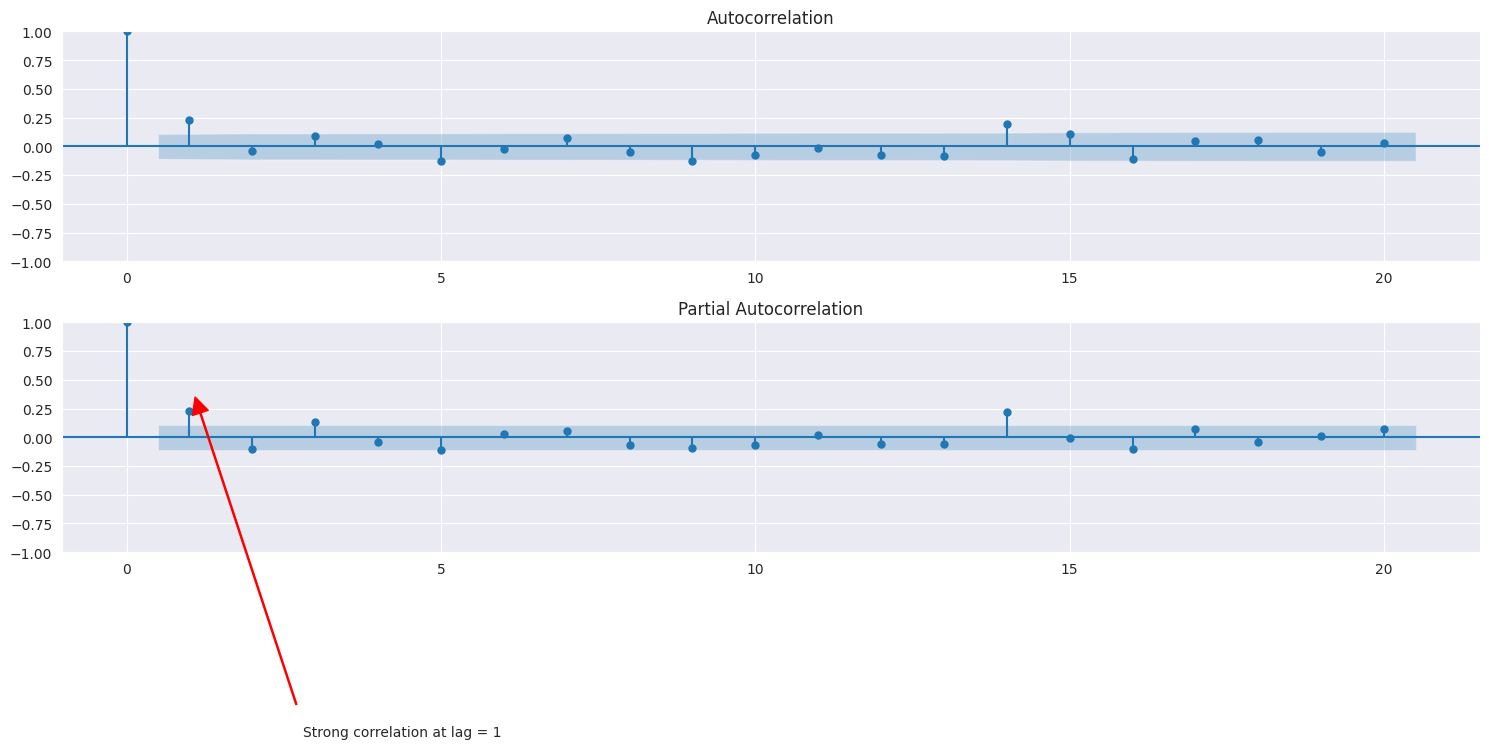

In [ ]:
# Draw ACF and PACF plots
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

plot_acf(imputed_data['Amount'], lags=lag_acf, ax=ax[0])
plot_pacf(imputed_data['Amount'], lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1',
               xy=(1, 0.5),
               xycoords='data',
               xytext=(0.17, -0.80),
               textcoords='axes fraction',
               arrowprops=dict(color='red',
               shrink=0.05, width=0.8))
plt.tight_layout()
plt.show()


# Get training and testing set

In [ ]:
# Calculate the training and testing start dates
train_start = imputed_data.index.min().date()
train_end = imputed_data.index.max().date() - timedelta(days=5)
test_start = imputed_data.index.max().date() - timedelta(days=4)
test_end = imputed_data.index.max().date()

In [ ]:
# Split the data into training and testing sets
train_data = imputed_data[(imputed_data.index.date >= train_start) & (imputed_data.index.date <= train_end)]
test_data = imputed_data[(imputed_data.index.date >= test_start) & (imputed_data.index.date <= test_end)]


In [ ]:
test_data=test_data['Amount']

In [ ]:
train_data=train_data['Amount']

In [ ]:
imputed_data=imputed_data['Amount']

In [ ]:
test_data

2018-12-25    116775.0
2018-12-26     11600.0
2018-12-27    116775.0
2018-12-28    116775.0
2018-12-29    117600.0
Freq: D, Name: Amount, dtype: float64

In [ ]:
train_data

2018-02-01    170350.0
2018-02-02     85140.0
2018-02-03     72700.0
2018-02-04    113750.0
2018-02-05    212680.0
2018-02-06    124610.0
2018-02-07     94450.0
2018-02-08    184560.0
2018-02-09     61230.0
2018-02-10    219940.0
2018-02-11    199880.0
2018-02-12     91350.0
2018-02-13     84180.0
2018-02-14    389290.0
2018-02-15    146000.0
2018-02-16     83000.0
2018-02-17     81590.0
2018-02-18    138330.0
2018-02-19    189590.0
2018-02-20    215860.0
2018-02-21     95220.0
2018-02-22    168980.0
2018-02-23    106650.0
2018-02-24    101150.0
2018-02-25    516390.0
2018-02-26    525970.0
2018-02-27    393770.0
2018-02-28    203530.0
2018-03-01    223720.0
2018-03-02    105600.0
2018-03-03     60940.0
2018-03-04    108760.0
2018-03-05    265090.0
2018-03-06    179860.0
2018-03-07    123990.0
2018-03-08    406590.0
2018-03-09     88340.0
2018-03-10    144090.0
2018-03-11    131700.0
2018-03-12    105760.0
2018-03-13     32890.0
2018-03-14      7960.0
2018-03-15     96950.0
2018-03-16 

# Modelling

In [ ]:
# Import Models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 1.Autoregressive Model (AR)

In [ ]:
# Build the Model
ar_model = ARIMA(train_data, order=(1,0,0)).fit()
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                  327
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4261.124
Date:                Thu, 17 Aug 2023   AIC                           8528.249
Time:                        08:08:46   BIC                           8539.618
Sample:                    02-01-2018   HQIC                          8532.785
                         - 12-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.473e+05   8075.230     18.245      0.000    1.32e+05    1.63e+05
ar.L1          0.2247      0.037      6.150      0.000       0.153       0.296
sigma2      1.223e+10      0.127   9.66e+10      0.0

**Predicted Model**

### $\hat{y_t} = (1.463e+05)+ 0.2198y_{t-1}$

**Prediction**

In [ ]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [ ]:
# Prediction
predAR = ar_model.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
pred_start_date

Timestamp('2018-12-25 00:00:00', freq='D')

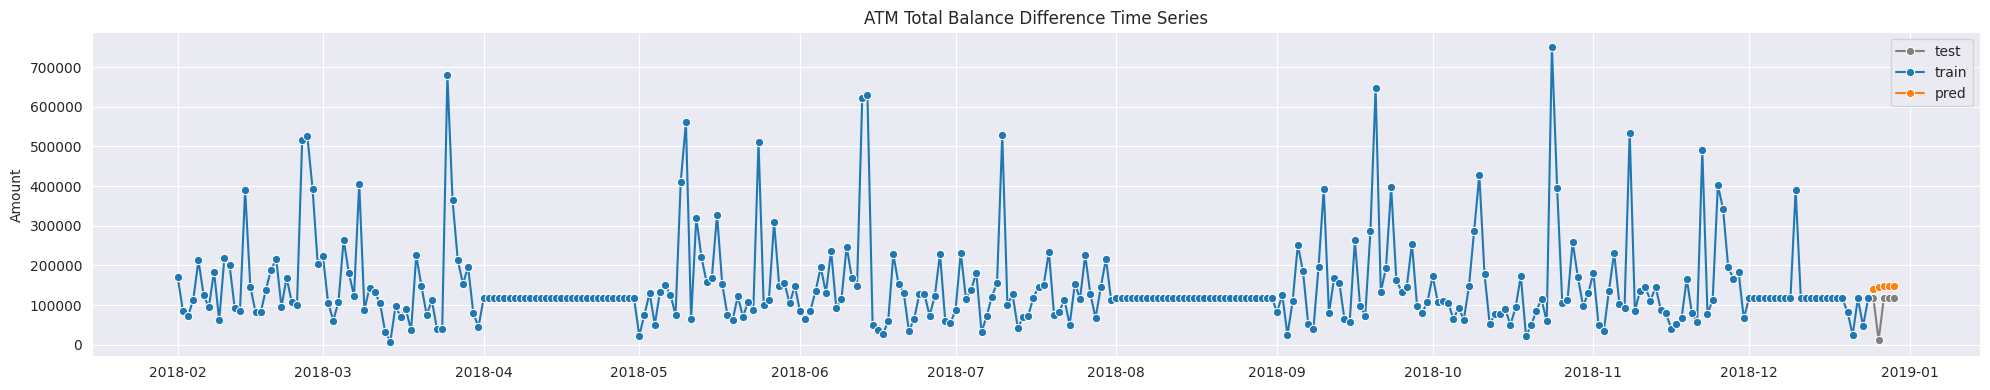

In [ ]:
# Plot the results
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=predAR.index, y=predAR, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Using Rolling Forecast Origin**

In [ ]:
ar_rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train = imputed_data[:train_end - timedelta(days=1)]
    model = ARIMA(train, order=(1,0,0))
    model_fit = model.fit()

    pred1 = model_fit.forecast()
    ar_rolling_predictions[train_end] = pred1

In [ ]:
ar_rolling_predictions

2018-12-25    140465.396117
2018-12-26    140387.887000
2018-12-27    116290.664213
2018-12-28    139970.409717
2018-12-29    139895.382726
Freq: D, Name: Amount, dtype: float64

In [ ]:
predAR

2018-12-25    140465.396117
2018-12-26    145788.938964
2018-12-27    146985.208892
2018-12-28    147254.026440
2018-12-29    147314.433271
Freq: D, Name: predicted_mean, dtype: float64

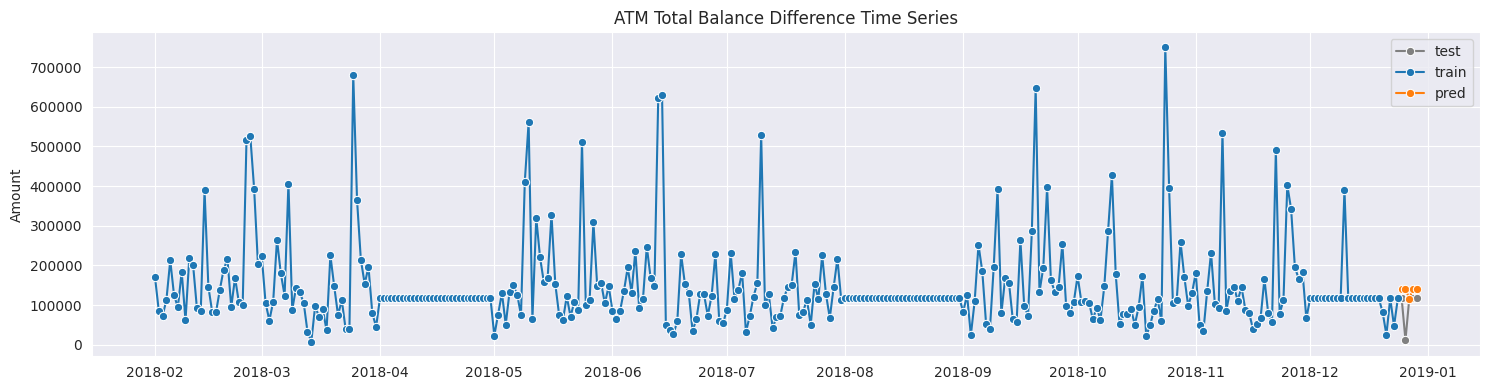

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=ar_rolling_predictions.index, y=ar_rolling_predictions, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Evaluation**

In [ ]:
ar_residuals = test_data - ar_rolling_predictions

In [ ]:
ar_residuals

2018-12-25    -23690.396117
2018-12-26   -128787.887000
2018-12-27       484.335787
2018-12-28    -23195.409717
2018-12-29    -22295.382726
Freq: D, Name: Amount, dtype: float64

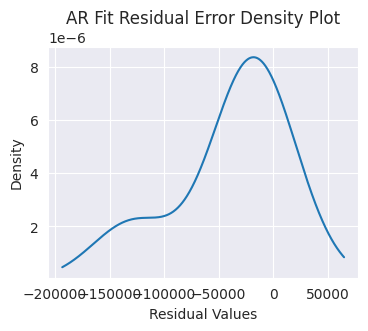

In [ ]:
# density plot of residuals
# Density plot of residuals
plt.figure(figsize=(4, 3))
plt.title('AR Fit Residual Error Density Plot')
plt.xlabel('Residual Values')
ar_residuals.plot(kind='kde')
plt.show()

In [ ]:
# Calculate RMSE (Root Mean Squared Error), MAPE (Mean Absolute Percentage Error) & Huber Loss
mape = round(np.mean(abs(ar_residuals / test_data)), 4)
rmse = np.sqrt(np.mean(ar_residuals ** 2))
huber = round(np.mean(huber_loss(ar_rolling_predictions, test_data, delta=1)), 4)

# h = tf.keras.losses.Huber()
# print(h(test, ar_residuals).numpy())

results = pd.DataFrame({'Method':['Autoregressive (AR)'],
                        'RMSE': [rmse],
                        'MAPE': [mape],
                        'Huber': [huber]})

results = results[['Method', 'RMSE', 'MAPE', 'Huber']]

results

,Method,RMSE,MAPE,Huber
0,Autoregressive (AR),60304.063561,2.3395,39690.1823


# 2. Moving Average Model (MA)

In [ ]:
ma_model = ARIMA(train_data, order=(0,0,1)).fit()
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                  327
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -4259.002
Date:                Thu, 17 Aug 2023   AIC                           8524.004
Time:                        08:08:51   BIC                           8535.374
Sample:                    02-01-2018   HQIC                          8528.541
                         - 12-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.473e+05   8203.356     17.960      0.000    1.31e+05    1.63e+05
ma.L1          0.2839      0.040      7.044      0.000       0.205       0.363
sigma2      1.214e+10      0.128   9.48e+10      0.0

##### **Predicted Model:**
  ### $\hat{y}_t = ( 1.463e+05 ) +  0.2797\varepsilon_{t-1}$

#### **Prediction**

In [ ]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [ ]:
predMA = ma_model.predict(start=pred_start_date, end=pred_end_date)

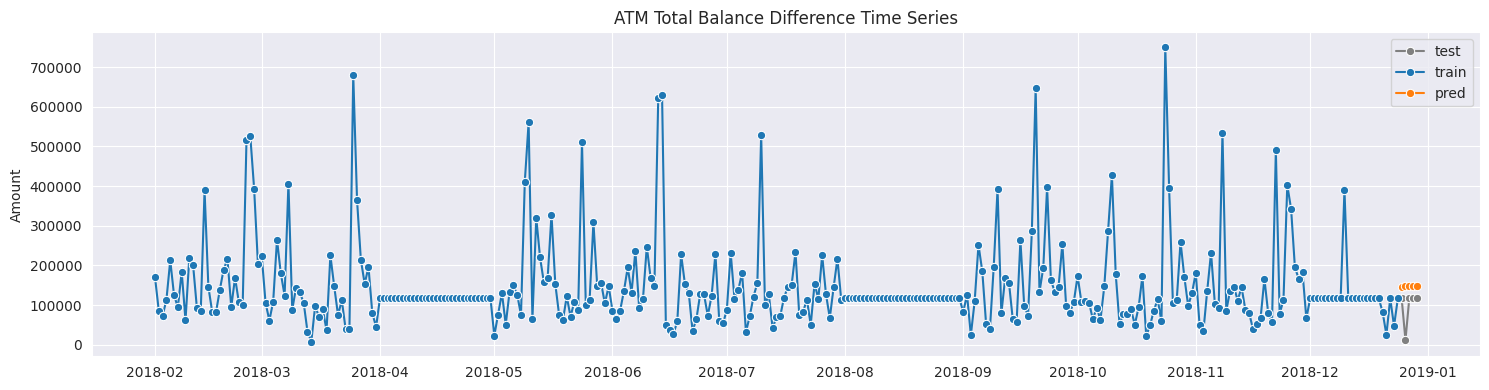

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=predMA.index, y=predMA, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Using Rolling Forecast Origin**


In [ ]:
ma_rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train = imputed_data[:train_end - timedelta(days=1)]
    model = ARIMA(train, order=(0,0,1))
    model_fit = model.fit()

    pred2 = model_fit.forecast()
    ma_rolling_predictions[train_end] = pred2

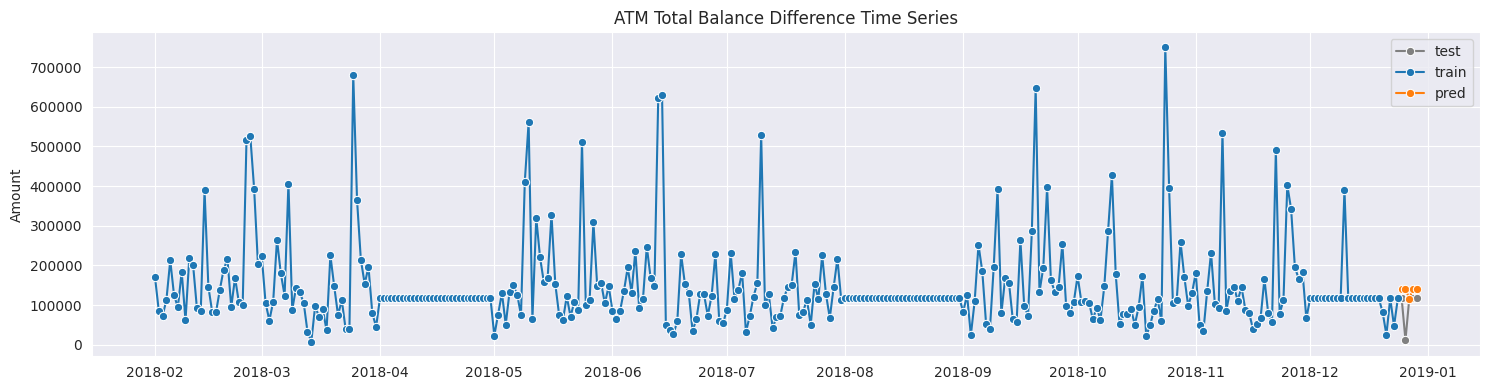

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=ar_rolling_predictions.index, y=ar_rolling_predictions, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Evaluation**

In [ ]:
ma_rolling_residuals = test_data - ma_rolling_predictions

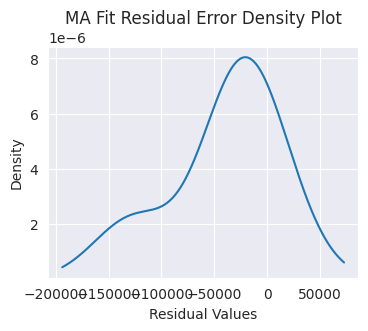

In [ ]:
# density plot of residuals
plt.figure(figsize=(4,3))
plt.title('MA Fit Residual Error Density Plot')
plt.xlabel('Residual Values')
ma_rolling_residuals.plot(kind='kde')
plt.show()

In [ ]:
# Calculate RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error)
mape = round(np.mean(abs(ma_rolling_residuals / test_data)), 4)
rmse = np.sqrt(np.mean(ma_rolling_residuals ** 2))

huber = round(np.mean(huber_loss(ma_rolling_predictions, test_data, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['Moving Average (MA)'],
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE', 'Huber']]
results

,Method,RMSE,MAPE,Huber
0,Autoregressive (AR),60304.063561,2.3395,39690.1823
0,Moving Average (MA),60848.256956,2.3427,42990.0257


# 3. Auto regression moving average method (ARMA)

In [ ]:
# Build the model
model = ARIMA(train_data, order=(1,1,0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                  327
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4310.070
Date:                Thu, 17 Aug 2023   AIC                           8624.140
Time:                        08:08:56   BIC                           8631.714
Sample:                    02-01-2018   HQIC                          8627.162
                         - 12-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3255      0.039     -8.298      0.000      -0.402      -0.249
sigma2      1.788e+10   2.27e-13   7.89e+22      0.000    1.79e+10    1.79e+10
Ljung-Box (L1) (Q):                   5.78   Jarque-

#### **Prediction**

In [ ]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [ ]:
# Predictions
predARMA = model.predict(start=pred_start_date, end=pred_end_date)

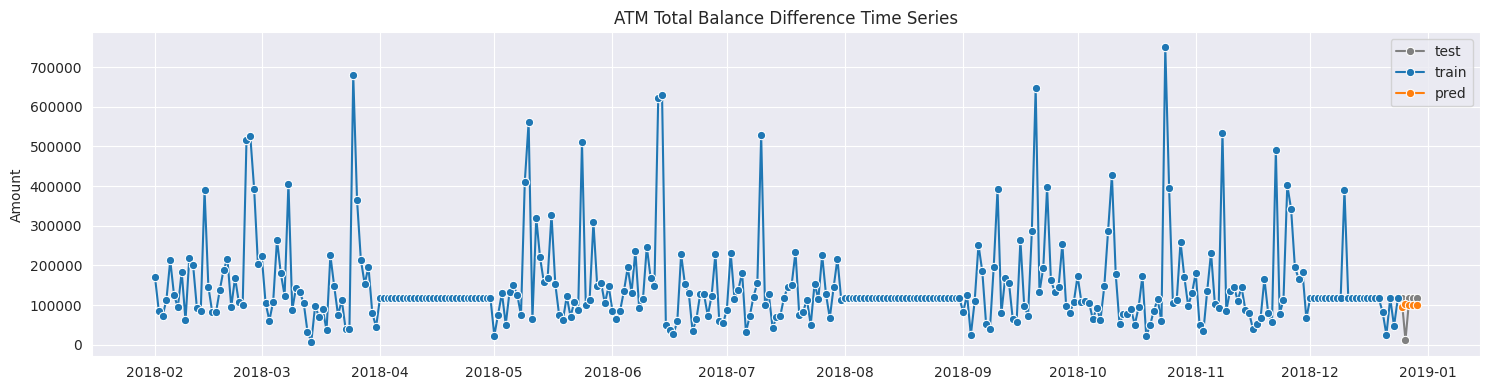

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=predARMA.index, y=predARMA, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Using Rolling Forecast Origin**

In [ ]:
arma_rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train = imputed_data[:train_end - timedelta(days=1)]
    model = ARIMA(train, order=(0,0,1))
    model_fit = model.fit()

    pred3 = model_fit.forecast()
    arma_rolling_predictions[train_end] = pred3[0]

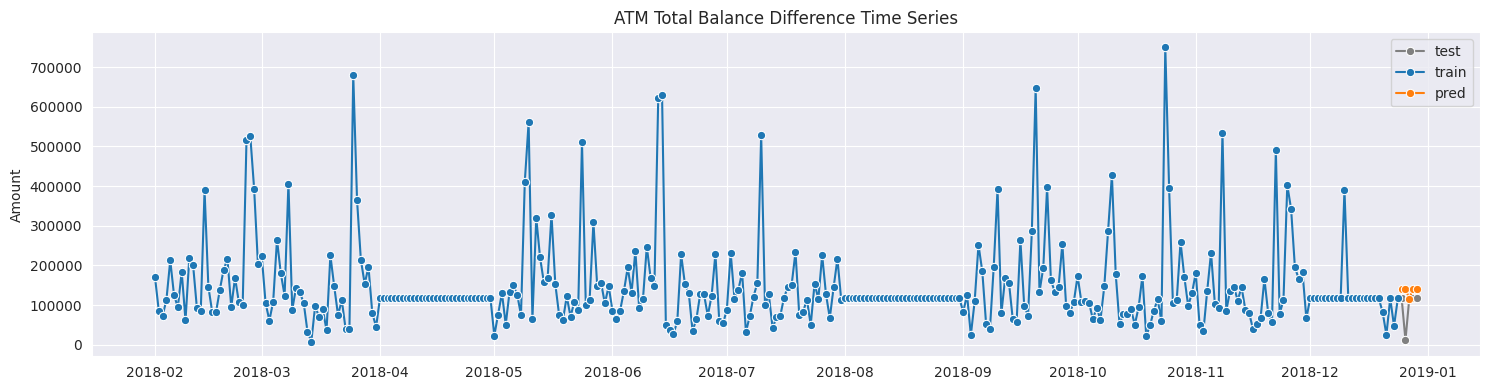

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=ar_rolling_predictions.index, y=ar_rolling_predictions, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Evaluation**

In [ ]:
arma_rolling_residuals = test_data - arma_rolling_predictions

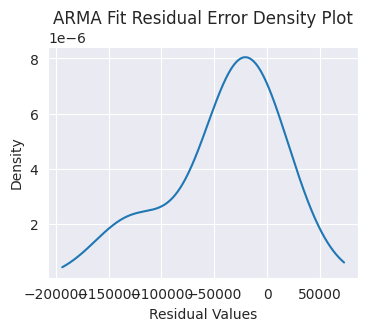

In [ ]:
# density plot of residuals
plt.figure(figsize=(4,3))
plt.title('ARMA Fit Residual Error Density Plot')
plt.xlabel('Residual Values')
arma_rolling_residuals.plot(kind='kde')
plt.show()

In [ ]:
# Calculate RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error)
mape = round(np.mean(abs(arma_rolling_residuals / test_data)), 4)
rmse = np.sqrt(np.mean(arma_rolling_residuals ** 2))
huber = round(np.mean(huber_loss(arma_rolling_predictions, test_data, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA)'],
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE', 'Huber']]
results

,Method,RMSE,MAPE,Huber
0,Autoregressive (AR),60304.063561,2.3395,39690.1823
0,Moving Average (MA),60848.256956,2.3427,42990.0257
0,Autoregressive moving average (ARMA),60848.256956,2.3427,42990.0257


# 4. Auto regressive integrated moving average (ARIMA)


In [ ]:
model = ARIMA(train_data, order=(1,1,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                  327
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4255.585
Date:                Thu, 17 Aug 2023   AIC                           8517.170
Time:                        08:09:01   BIC                           8528.531
Sample:                    02-01-2018   HQIC                          8521.704
                         - 12-24-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2285      0.047      4.912      0.000       0.137       0.320
ma.L1         -0.9972      0.033    -30.454      0.000      -1.061      -0.933
sigma2       1.56e+10   1.43e-12   1.09e+22      0.0

#### **Prediction**

In [ ]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [ ]:
predARIMA= model.predict(start=pred_start_date, end=pred_end_date)

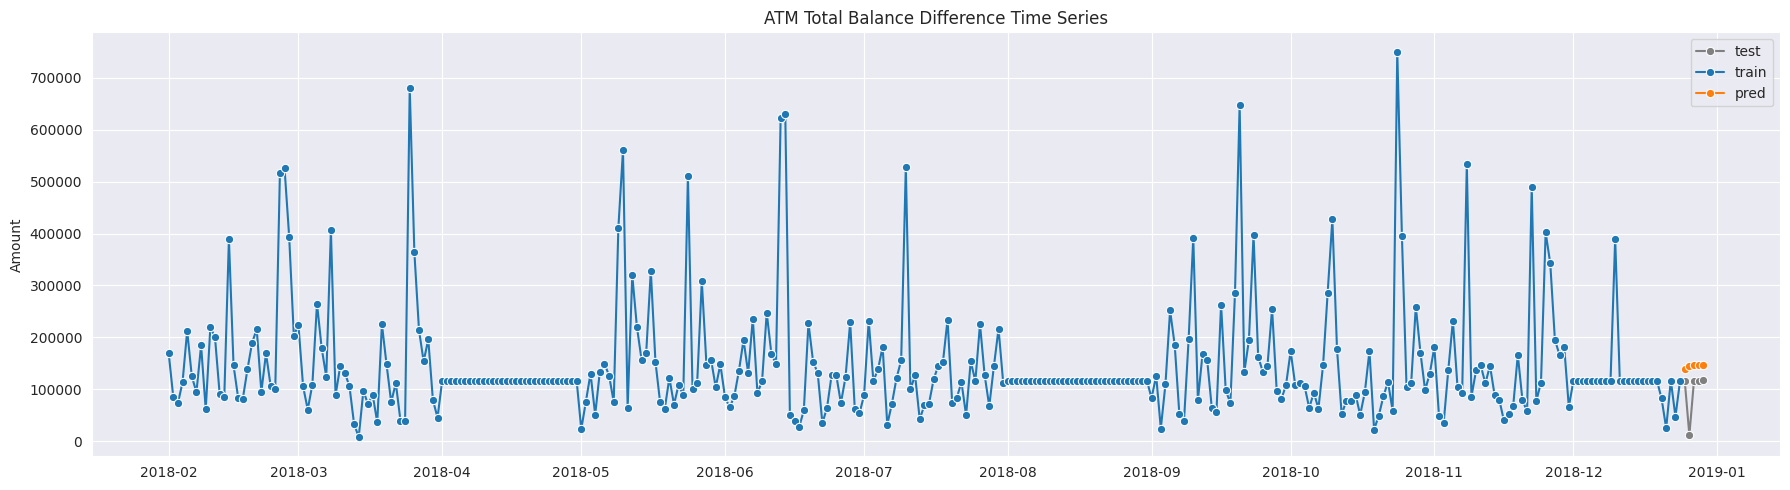

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))

sns.lineplot(x=test_data.index, y=test_data, marker='o', label='test', color='grey')
sns.lineplot(x=train_data.index, y=train_data, marker='o', label='train')
sns.lineplot(x=predARIMA.index, y=predARIMA, marker='o', label='pred')

#ax.set_xlim([imputed_data.index[0], imputed_data.index[-1]])
ax.set_title('ATM Total Balance Difference Time Series')
plt.tight_layout()
plt.show()

#### **Evaluation**

In [ ]:
arima_residuals = test_data - predARIMA

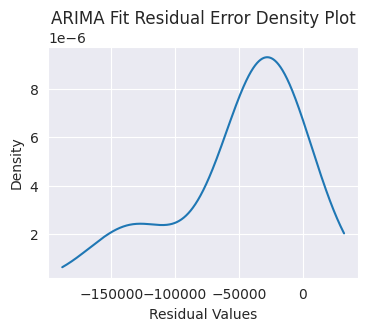

In [ ]:
# density plot of residuals
plt.figure(figsize=(4,3))
plt.title('ARIMA Fit Residual Error Density Plot')
plt.xlabel('Residual Values')
arima_residuals.plot(kind='kde')
plt.show()

In [ ]:
arima_residuals

2018-12-25    -22839.477320
2018-12-26   -133234.121215
2018-12-27    -29251.998005
2018-12-28    -29524.613353
2018-12-29    -28761.915788
Freq: D, dtype: float64

In [ ]:
# Calculate RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error)
mape = round(np.mean(abs(arima_residuals / test_data)), 4)
rmse = np.sqrt(np.mean(arima_residuals ** 2))
huber = round(np.mean(huber_loss(predARIMA, test_data, delta=1)), 4)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA)'],
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE', 'Huber']]
results

,Method,RMSE,MAPE,Huber
0,Autoregressive (AR),60304.063561,2.3395,39690.1823
0,Moving Average (MA),60848.256956,2.3427,42990.0257
0,Autoregressive moving average (ARMA),60848.256956,2.3427,42990.0257
0,Autoregressive integrated moving average (ARIMA),64540.844062,2.4858,48721.9251


# 5. LSTM


In [ ]:
# import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df=df['Amount']

In [ ]:
dataset = df.copy()
dataset = pd.DataFrame(dataset)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i + look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.86)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
210/210 - 2s - loss: 0.0462 - 2s/epoch - 11ms/step
Epoch 2/100
210/210 - 0s - loss: 0.0309 - 313ms/epoch - 1ms/step
Epoch 3/100
210/210 - 0s - loss: 0.0305 - 320ms/epoch - 2ms/step
Epoch 4/100
210/210 - 0s - loss: 0.0304 - 331ms/epoch - 2ms/step
Epoch 5/100
210/210 - 0s - loss: 0.0305 - 307ms/epoch - 1ms/step
Epoch 6/100
210/210 - 0s - loss: 0.0304 - 311ms/epoch - 1ms/step
Epoch 7/100
210/210 - 0s - loss: 0.0305 - 307ms/epoch - 1ms/step
Epoch 8/100
210/210 - 0s - loss: 0.0302 - 324ms/epoch - 2ms/step
Epoch 9/100
210/210 - 0s - loss: 0.0304 - 300ms/epoch - 1ms/step
Epoch 10/100
210/210 - 0s - loss: 0.0302 - 309ms/epoch - 1ms/step
Epoch 11/100
210/210 - 0s - loss: 0.0302 - 306ms/epoch - 1ms/step
Epoch 12/100
210/210 - 0s - loss: 0.0301 - 304ms/epoch - 1ms/step
Epoch 13/100
210/210 - 0s - loss: 0.0301 - 292ms/epoch - 1ms/step
Epoch 14/100
210/210 - 0s - loss: 0.0302 - 308ms/epoch - 1ms/step
Epoch 15/100
210/210 - 0s - loss: 0.0300 - 320ms/epoch - 2ms/step
Epoch 16/100
210/210 

#### **Prediction**

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 32ms/step


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

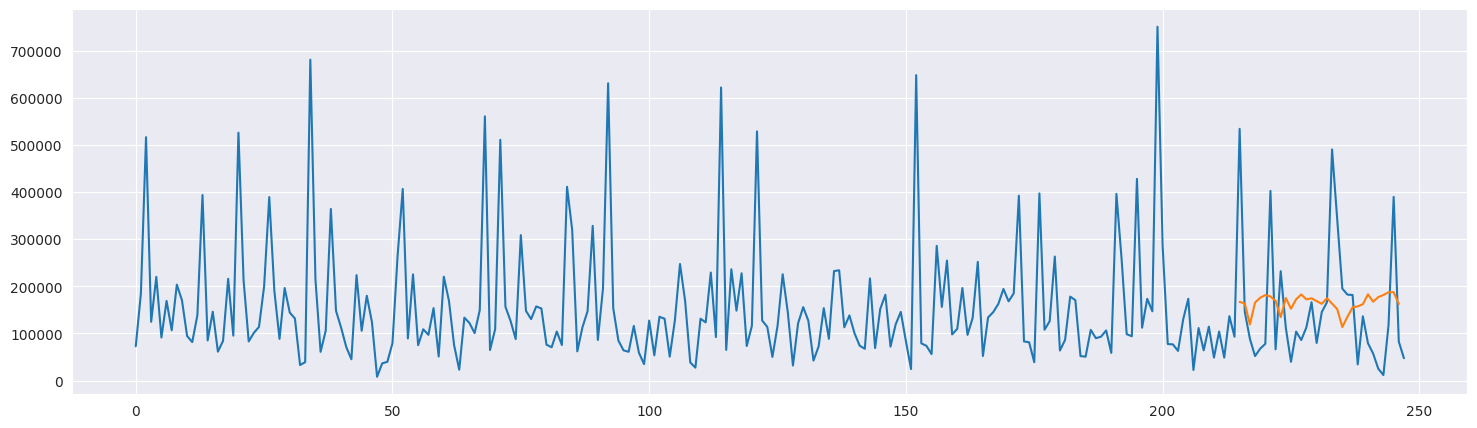

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+ + (look_back* 2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(18, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.show()

#### **Evaluation**

In [ ]:
lstm_residuals = testY[0] - testPredict.T[0]

In [ ]:
# Calculate RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error)
mape = round(np.mean(abs(lstm_residuals / testY[0])), 4)
rmse = np.sqrt(np.mean(lstm_residuals ** 2))
huber = round(np.mean(huber_loss(testPredict.T[0], testY[0], delta=1)), 4)

tempResults = pd.DataFrame({'Method':['Long Short-term Memory (LSTM)'],
                            'RMSE': [rmse],
                            'MAPE': [mape],
                            'Huber': [huber]})

results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE', 'Huber']]
results

,Method,RMSE,MAPE,Huber
0,Autoregressive (AR),60304.063561,2.3395,39690.1823
0,Moving Average (MA),60848.256956,2.3427,42990.0257
0,Autoregressive moving average (ARMA),60848.256956,2.3427,42990.0257
0,Autoregressive integrated moving average (ARIMA),64540.844062,2.4858,48721.9251
0,Long Short-term Memory (LSTM),134628.284113,1.4901,106176.4565
